# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as req
import re
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [2]:
df = pd.read_csv('main_task_new.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [4]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки
from bs4 import BeautifulSoup
import requests as req

## Обработка 'Price Range', как ординального признака

In [5]:
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [6]:
# добавляем столбец для сохранения информации, что у этих ресторанов не было данных о цене
df['Price Range NAN'] = df['Price Range'].isnull() * 1

In [7]:
# словарь, по которому будем разбивать признак
dictionary = {"$$ - $$$":1, '$':0, "$$$$":2}

In [8]:
df['Price Range'] = df['Price Range'].replace(dictionary)

In [9]:
# заполняем пропуски средним значением
df['Price Range'] = df['Price Range'].fillna(1)

In [10]:
df['Price Range'].value_counts()

1.0    32298
0.0     6279
2.0     1423
Name: Price Range, dtype: int64

--------

## Обработка 'Cuisine Style'

In [11]:
#df['Cuisine Style'].unique()

In [12]:
df['Cuisine Style NAN'] = df['Cuisine Style'].isnull() * 1

---------------------

## Обработка 'Number of Reviews'

In [13]:
df['Number of Reviews'].value_counts(bins = 20)

(-7.659000000000001, 484.9]    35271
(484.9, 967.8]                  1484
(967.8, 1450.7]                  410
(1450.7, 1933.6]                 141
(1933.6, 2416.5]                  65
(2416.5, 2899.4]                  27
(2899.4, 3382.3]                  21
(3382.3, 3865.2]                  11
(3865.2, 4348.1]                   7
(4348.1, 4831.0]                   7
(5796.8, 6279.7]                   3
(4831.0, 5313.9]                   3
(6279.7, 6762.6]                   2
(7245.5, 7728.4]                   2
(6762.6, 7245.5]                   1
(8694.2, 9177.1]                   1
(9177.1, 9660.0]                   1
(5313.9, 5796.8]                   0
(7728.4, 8211.3]                   0
(8211.3, 8694.2]                   0
Name: Number of Reviews, dtype: int64

In [14]:
df['Number of Reviews'].max()

9660.0

видим, что большая часть данных лежит в одной корзине

<AxesSubplot:>

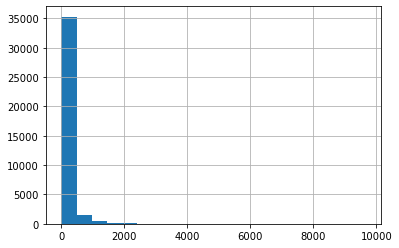

In [15]:
df['Number of Reviews'].hist(bins = 20)

In [16]:
# логично предположить, что если у нас нет данных о кол-ве отзывов, это означает, что отзывов нет совсем
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

попробуем разделить этот признак на 10 равных корзин по кол-ву вхождений

In [17]:
bin_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

df['Number of Reviews_bins'] = pd.qcut(df['Number of Reviews'],
                              q=10,
                              labels=bin_labels)

In [18]:
df['Number of Reviews_bins'].value_counts()

0    4459
1    4187
4    4170
6    4052
8    3999
9    3997
7    3940
3    3936
5    3754
2    3506
Name: Number of Reviews_bins, dtype: int64

так же попробуем создать новый признак - логорифм от кол-ва отзывов

In [19]:
df['Number of Reviews_lg'] = np.log(df['Number of Reviews']+1)
#df['Number of Reviews_lg'] = np.sqrt(df['Number of Reviews'])

<AxesSubplot:>

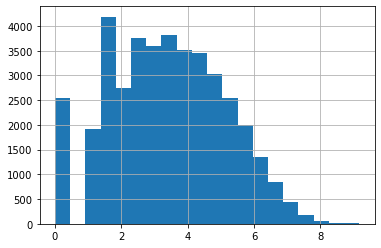

In [20]:
df['Number of Reviews_lg'].hist(bins = 20)

In [21]:
df['Number of Reviews_lg'].value_counts()

0.000000    2543
1.098612    1916
1.386294    1636
1.609438    1370
1.791759    1181
            ... 
6.919684       1
7.495542       1
7.064759       1
6.450470       1
8.687442       1
Name: Number of Reviews_lg, Length: 1460, dtype: int64

---------------

## Обработка и получение новых признаков из отзывов

In [22]:
df['Reviews'].sample(10)

34503    [['Breakfast and dinner', 'An interesting alte...
18802    [['Best soft ice cream I ever had'], ['04/17/2...
18116                                             [[], []]
13704    [['Little Gem', 'NICE & FRIENDLY PLACE'], ['01...
6552     [['Bad Service & expensive', 'Visit Drimnagh C...
19079                                             [[], []]
36977    [['Lunch with kids', 'Excellent service , food...
4626     [['Great service and pizza', 'Delicious food, ...
9535     [['Brilliant', 'Great local spot'], ['11/22/20...
10807    [['Outstanding Cocktail Masterclass!! Awesome....
Name: Reviews, dtype: object

По полученным данным видим, гипотетически можем вытащить время, когда были оставлены два отзыва (если они были оставлены). В идеале можно прогнать через какой-нибудь алгоритм сами отзывы, чтобы получить по ним эмоциональную окраску, но времени на это нет, поэтому возьмем толко разницу между датами оставленных отзывов, и как давно был сделан последний отзыв.

In [23]:
# функция для нахождения дат в колонке отзывов
def time_func(row):
    txt = row['Reviews']
    list_of_times = re.findall(r'\d\d/\d\d/\d{4}', txt) # для поиска используем регулярные выражения
    if len(list_of_times) > 0:
        row['time1'] = list_of_times[0]
    else:
        row['time1'] = None
    if len(list_of_times) > 1:
        row['time2'] = list_of_times[1]
    else:
        row['time2'] = None
    return row

In [24]:
# применяем функцию ко всему датафрейму, чтобы создать новые столбцы
df = df.apply(time_func, axis = 1)

In [25]:
# переводим в формат даты
df['time1'] = pd.to_datetime(df['time1'])
df['time2'] = pd.to_datetime(df['time2'])
# заполняем новый столбец текущей датой
df['today'] = pd.to_datetime(pd.Timestamp('today').date())
# заполняем новый столбец датой последнего отзыва по всему датафрейму (от этой даты будем отсчитывать давность отзыва о ресторане)
df['last_review'] = max(df['time1'].max(), df['time2'].max())

In [26]:
# заполняем пропуски самыми давними датами (за неимением лучшей идеи)
df['time1'] = df['time1'].fillna(df['time1'].min())
df['time2'] = df['time2'].fillna(df['time2'].min())

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Restaurant_id           40000 non-null  object        
 1   City                    40000 non-null  object        
 2   Cuisine Style           30717 non-null  object        
 3   Ranking                 40000 non-null  float64       
 4   Rating                  40000 non-null  float64       
 5   Price Range             40000 non-null  float64       
 6   Number of Reviews       40000 non-null  float64       
 7   Reviews                 40000 non-null  object        
 8   URL_TA                  40000 non-null  object        
 9   ID_TA                   40000 non-null  object        
 10  Price Range NAN         40000 non-null  int64         
 11  Cuisine Style NAN       40000 non-null  int64         
 12  Number of Reviews_bins  40000 non-null  int64 

In [28]:
# вычисляем "частоту" отзывов
df['day_freq'] = (df['time1']-df['time2']).dt.days
#df['day_space1'] = (df['today']-df['time1']).dt.days
#df['day_space2'] = (df['today']-df['time2']).dt.days
# вычисляем как давно были сделаны отзывы
df['day_space1'] = (df['last_review']-df['time1']).dt.days
df['day_space2'] = (df['last_review']-df['time2']).dt.days

In [29]:
# выбираем последний отзыв
df['day_space'] = df[['day_space1','day_space2']].min(axis=1)

In [30]:
# удаляем ненужные столбцы
df = df.drop(['day_space1', 'day_space2','today', 'time1', 'time2', 'last_review'], axis = 1)

In [31]:
# избавляемся от отрицательных значений
df['day_freq'] = abs(df['day_freq'])

In [32]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Price Range NAN,Cuisine Style NAN,Number of Reviews_bins,Number of Reviews_lg,day_freq,day_space
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,1.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,8,5.273000,41,57
1,id_1535,Stockholm,NaN,1537.0,4.0,1.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,1,3,2.397895,382,235
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,2.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,9,6.535241,2,49
3,id_3456,Berlin,NaN,3458.0,5.0,1.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,1,1.386294,1302,3757
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,1.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,0,7,4.442651,272,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,1.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,0,0,6,4.382027,34,72
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,1.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,0,0,9,6.297109,9,67
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,1.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,0,1,1.609438,3127,480
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,1.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,0,0,6,4.262680,23,230


--------

## Обработка 'Ranking'

По сути, обработка сводится к нормировке этого столбца по городам.

Попробуем определить худший рейтинг по городам и принять его за основу нормировки (т.е. допустим, что кол-во рестораном в этом городе ограничивается рейтингом этого худшего ресторана.

In [33]:
# создадим список городов
cities = df['City'].unique()
# словарь, в котором сохраним основы нормировки по городам
dictionary = {}
for city in cities:
    number = df['Ranking'][df['City'] == city].max()
    dictionary[city] = number
    
print(dictionary)

{'Paris': 13986.0, 'Stockholm': 2464.0, 'London': 16444.0, 'Berlin': 6372.0, 'Munich': 2763.0, 'Oporto': 1484.0, 'Milan': 6275.0, 'Bratislava': 889.0, 'Vienna': 3444.0, 'Rome': 5946.0, 'Barcelona': 7796.0, 'Madrid': 8809.0, 'Dublin': 1960.0, 'Brussels': 3004.0, 'Zurich': 1590.0, 'Warsaw': 2141.0, 'Budapest': 2438.0, 'Copenhagen': 1964.0, 'Amsterdam': 3249.0, 'Lyon': 2666.0, 'Hamburg': 2736.0, 'Lisbon': 3717.0, 'Prague': 4188.0, 'Oslo': 1137.0, 'Helsinki': 1141.0, 'Edinburgh': 1766.0, 'Geneva': 1413.0, 'Ljubljana': 468.0, 'Athens': 1787.0, 'Luxembourg': 621.0, 'Krakow': 1244.0}


In [34]:
# функция для нормирования
def delta_ranking(row):
    row['ranking_d'] = row['Ranking']/dictionary[row['City']]
    return row

In [35]:
df = df.apply(delta_ranking, axis = 1)

Можно попробовать уточнить данные нормировки. На сайте tripadviser на страницах ресторанов есть информация на каком месте рейтинга стоит ресторан и общее число ресторанов в этом городе. Попытаемся взять основу нормировки оттуда.

In [36]:
# создаем новый словарь
dictionary_abs = {}
for city in cities:
    print('start for city: ', city)
    url_base = 'https://www.tripadvisor.ru'
    # делаем срез датафрейма с текущим городом
    city_df = df[df['City'] == city]
    flag = True
    while flag:
        # находим индекс ресторана с худшим (наибольшим) рангом в этом городе
        i = city_df['Ranking'].idxmax()
        print(i)
        # создаем link на страницу обзора этого ресторана на tripadviser
        url = url_base + city_df.loc[i]['URL_TA']
        print(url)
        # создаем сессию подключения через контекстное меню
        with req.Session() as s:
            # пытаемся подключиться до 20 раз
            for effort in range(20):
                try:
                    #resp = s.get(url_base, timeout=5, headers={'User-Agent': 'some cool user-agent'})
                    #url = 'https://www.tripadvisor.ru/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html'
                    print('trying....')
                    resp = s.get(url, timeout=2, headers={'User-Agent': 'some cool user-agent'})
                    break
                except Exception as exc:
                    print('Error!' + str(exc))
            print(resp)
            # создаем объект для разбора html файла
            soup = BeautifulSoup(resp.text, 'lxml')
            # находим интересующий нас тег
            txt = soup.find_all('a', attrs={'class': 'fhGHT'})
            print(txt)
            # иничтожаем в текущем срезе строку с худшим рейтингом
            # если не получим нужную информацию с этой страницы, по циклу перейдем к ресторану со следующим по размеру рангом
            city_df.drop(i, inplace=True)
            if txt:
                # если удалось получить информацию по тегу, сохраняем ее как текст
                txt = txt[0].contents[0].text
                # удаляем длинные пробелы
                txt = re.sub(r'\xa0', '', txt)
                # ищем числа с помощью регулярных выражений
                list_of_rank = re.findall(r'\d+', txt)
                if len(list_of_rank) > 0:
                    print(int(list_of_rank[0]))
                if len(list_of_rank) > 1:
                    print(list_of_rank[1])
                    # для словаря выбираем максимальное значение из скачанного и значения предыдущего словаря
                    dictionary_abs[city] = max(int(list_of_rank[1]), dictionary[city])
                    # условие выхода из цикла (получили искомое значение для нормировки этого города)
                    flag = False
                print()
print(dictionary_abs)

start for city:  Paris
17304
https://www.tripadvisor.ru/Restaurant_Review-g187147-d719135-Reviews-Le_Huitieme_Sud-Paris_Ile_de_France.html
trying....
<Response [200]>
[<a class="fhGHT" href="/Restaurants-g187147-Paris_Ile_de_France.html"><span><b><span>#14 779</span></b> из 15 714 ресторанов в Париж</span></a>, <a class="fhGHT" href="#MAPVIEW">Franklin Roosevelt 13 rue de la Tremoille, 75008 Париж Франция</a>]
14779
15714

start for city:  Stockholm
15290
https://www.tripadvisor.ru/Restaurant_Review-g189852-d7133658-Reviews-Skanstull_Restaurang_Radiobar-Stockholm.html
trying....


C:\Users\garshenin\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<Response [200]>
[<a class="fhGHT" href="/Restaurants-g189852-Stockholm.html"><span><b><span>#2 647</span></b> из 2 794 ресторанов в Стокгольм</span></a>, <a class="fhGHT" href="#MAPVIEW">71 Regeringsgatan, Стокгольм 111 56 Швеция</a>]
2647
2794

start for city:  London
25545
https://www.tripadvisor.ru/Restaurant_Review-g186338-d720554-Reviews-Singapura_Blackfriars-London_England.html
trying....
Error!HTTPSConnectionPool(host='www.tripadvisor.ru', port=443): Read timed out. (read timeout=2)
trying....
Error!HTTPSConnectionPool(host='www.tripadvisor.ru', port=443): Max retries exceeded with url: /Restaurant_Review-g186338-d720554-Reviews-Singapura_Blackfriars-London_England.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D25A340100>, 'Connection to www.tripadvisor.ru timed out. (connect timeout=2)'))
trying....
Error!HTTPSConnectionPool(host='www.tripadvisor.ru', port=443): Max retries exceeded with url: /Restaurant_Review-g186338-d720554-Review

<Response [200]>
[<a class="fhGHT" href="/Restaurants-g187497-Barcelona_Catalonia.html"><span><b><span>#8 674</span></b> из 8 757 ресторанов в Барселона</span></a>, <a class="fhGHT" href="#MAPVIEW">Carrer de Sant Antoni Maria Claret, S/N, Барселона Испания</a>]
8674
8757

start for city:  Madrid
7379
https://www.tripadvisor.ru/Restaurant_Review-g187514-d9826259-Reviews-Stop-Madrid.html
trying....
<Response [200]>
[<a class="fhGHT" href="/Restaurants-g187514-Madrid.html"><span><b><span>#9 541</span></b> из 10 407 ресторанов в Мадрид</span></a>, <a class="fhGHT" href="#MAPVIEW">Avenida Alberto Alcocer 32, 28036 Мадрид Испания</a>, <a class="dOGcA Ci Wc _S C fhGHT" data-encoded-url="TU8xX2h0dHBzOi8vd3d3LmZhY2Vib29rLmNvbS9zdG9wbWFkcmlkYWxiZXJ0b2FsY29jZXIvX3pkcQ==" referrerpolicy="origin" target="_blank">Веб-сайт<svg class="fecdL d Vb wQMPa" height="1em" viewbox="0 0 24 24" width="1em"><path d="M7.561 15.854l-1.415-1.415 8.293-8.293H7.854v-2h10v10h-2V7.561z"></path></svg></a>]
9541
10407

s

<Response [200]>
[<a class="fhGHT" href="/Restaurants-g187331-Hamburg.html"><span><b><span>#2 849</span></b> из 2 885 ресторанов в Гамбург</span></a>, <a class="fhGHT" href="#MAPVIEW">Johann Meyer Strasse 58, 21031 Гамбург Германия</a>]
2849
2885

start for city:  Lisbon
9097
https://www.tripadvisor.ru/Restaurant_Review-g189158-d13163518-Reviews-Li28oa_Wine_and_Tapas-Lisbon_Lisbon_District_Central_Portugal.html
trying....
Error!HTTPSConnectionPool(host='www.tripadvisor.ru', port=443): Max retries exceeded with url: /Restaurant_Review-g189158-d13163518-Reviews-Li28oa_Wine_and_Tapas-Lisbon_Lisbon_District_Central_Portugal.html (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001D2533B2CD0>, 'Connection to www.tripadvisor.ru timed out. (connect timeout=2)'))
trying....
<Response [200]>
[<a class="fhGHT" href="/Restaurants-g189158-Lisbon_Lisbon_District_Central_Portugal.html"><span><b><span>#64</span></b> из 4 598 ресторанов в Лиссабон</span></a>, <a class=


33745
https://www.tripadvisor.ru/Restaurant_Review-g274772-d12188784-Reviews-Olimp_Pilot_Tower-Krakow_Lesser_Poland_Province_Southern_Poland.html
trying....
<Response [200]>
[<a class="fhGHT" href="/Restaurants-g274772-Krakow_Lesser_Poland_Province_Southern_Poland.html"><span><b><span>#1 474</span></b> из 1 523 ресторанов в Краков</span></a>, <a class="fhGHT" href="#MAPVIEW">Pilotow 10, Краков Польша</a>, <a class="dOGcA Ci Wc _S C fhGHT" data-encoded-url="bVBnX2h0dHA6Ly9vbGltcHJlc3QucGwvX2IxdQ==" referrerpolicy="origin" target="_blank">Веб-сайт<svg class="fecdL d Vb wQMPa" height="1em" viewbox="0 0 24 24" width="1em"><path d="M7.561 15.854l-1.415-1.415 8.293-8.293H7.854v-2h10v10h-2V7.561z"></path></svg></a>]
1474
1523

{'Paris': 15714, 'Stockholm': 2794, 'London': 17319, 'Berlin': 6372.0, 'Munich': 2887, 'Oporto': 1863, 'Milan': 6776, 'Bratislava': 1045, 'Vienna': 3837, 'Rome': 10409, 'Barcelona': 8757, 'Madrid': 10407, 'Dublin': 2117, 'Brussels': 3004.0, 'Zurich': 1680, 'Warsaw': 27

In [37]:
# функция для новой нормировки
def delta_ranking_abs(row):
    row['ranking_a'] = row['Ranking']/dictionary_abs[row['City']]
    return row

In [38]:
df = df.apply(delta_ranking_abs, axis = 1)

In [39]:
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Price Range NAN,Cuisine Style NAN,Number of Reviews_bins,Number of Reviews_lg,day_freq,day_space,ranking_d,ranking_a
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,1.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,0,8,5.273000,41,57,0.398255,0.354461
1,id_1535,Stockholm,NaN,1537.0,4.0,1.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,1,3,2.397895,382,235,0.623782,0.550107
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,2.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,0,9,6.535241,2,49,0.021467,0.020382
3,id_3456,Berlin,NaN,3458.0,5.0,1.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,1,1,1.386294,1302,3757,0.542687,0.542687
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,1.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,0,7,4.442651,272,100,0.224756,0.215102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,1.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,0,0,6,4.382027,34,72,0.079681,0.073790
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,1.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,0,0,9,6.297109,9,67,0.453382,0.403526
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,1.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,0,1,1.609438,3127,480,0.670455,0.591267
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,1.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,0,0,6,4.262680,23,230,0.299393,0.230659


посмотрим корреляцию признаков

In [40]:
df.corr()

,Ranking,Rating,Price Range,Number of Reviews,Price Range NAN,Cuisine Style NAN,Number of Reviews_bins,Number of Reviews_lg,day_freq,day_space,ranking_d,ranking_a
Ranking,1.000000,-0.368371,-0.026525,-0.222072,0.233043,0.147995,-0.329987,-0.329741,0.140688,0.148369,0.572154,0.579855
Rating,-0.368371,1.000000,-0.028588,0.026924,-0.064567,-0.038263,-0.014180,-0.007666,-0.006566,-0.045036,-0.544573,-0.555482
Price Range,-0.026525,-0.028588,1.000000,0.107162,0.209937,0.158268,0.029542,0.038399,0.025209,0.080207,-0.047477,-0.036950
Number of Reviews,-0.222072,0.026924,0.107162,1.000000,-0.266797,-0.201311,0.513138,0.600741,-0.221223,-0.207771,-0.406030,-0.407546
Price Range NAN,0.233043,-0.064567,0.209937,-0.266797,1.000000,0.753881,-0.654368,-0.632125,0.429039,0.473959,0.462291,0.463648
Cuisine Style NAN,0.147995,-0.038263,0.158268,-0.201311,0.753881,1.000000,-0.477373,-0.460550,0.317354,0.302036,0.321586,0.325171
Number of Reviews_bins,-0.329987,-0.014180,0.029542,0.513138,-0.654368,-0.477373,1.000000,0.979834,-0.529530,-0.516372,-0.647875,-0.653600
Number of Reviews_lg,-0.329741,-0.007666,0.038399,0.600741,-0.632125,-0.460550,0.979834,1.000000,-0.531911,-0.519884,-0.644604,-0.649653
day_freq,0.140688,-0.006566,0.025209,-0.221223,0.429039,0.317354,-0.529530,-0.531911,1.000000,0.336186,0.354493,0.337052
day_space,0.148369,-0.045036,0.080207,-0.207771,0.473959,0.302036,-0.516372,-0.519884,0.336186,1.000000,0.370756,0.343930


<AxesSubplot:>

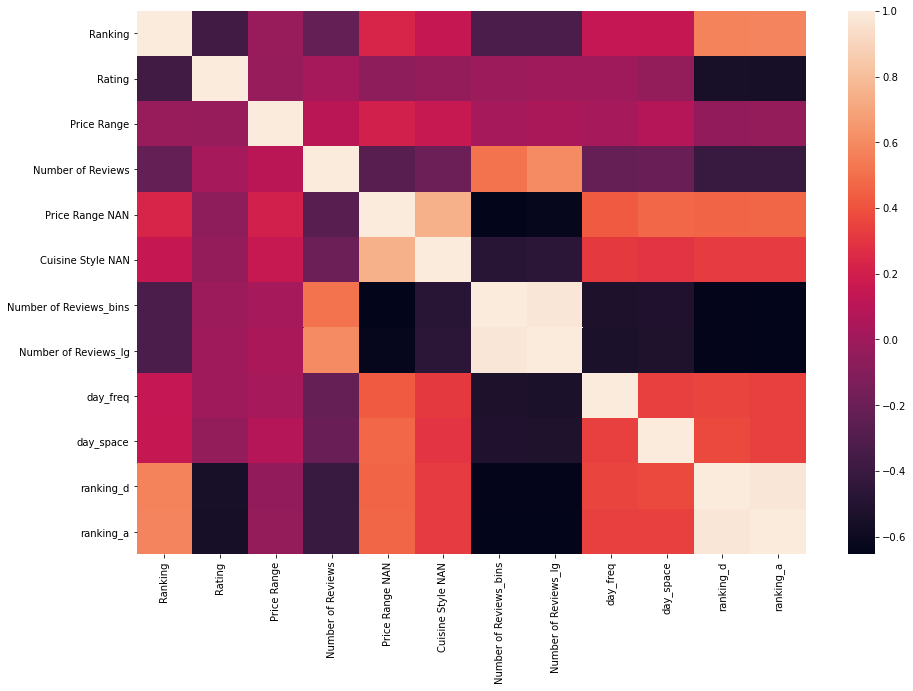

In [41]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.corr())

По корреляции можно сделать вывод что есть почти полностью скоррелированные столбцы (ranking_d : ranking_a Number of и Reviews_bins :Number of Reviews_ln) впоследствии избавимся от каждого в паре, который имеет меньшую корреляцию с таргетным признаком. rating_d дает почти тот же результат, что и rating_a и работает быстрее, но все же менее точен.

## Обработка 'City', работа с dummy переменными

In [42]:
# пользуемся специальной функцией, она сама все сделает
df = pd.get_dummies(df, columns=["City"])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           40000 non-null  object 
 1   Cuisine Style           30717 non-null  object 
 2   Ranking                 40000 non-null  float64
 3   Rating                  40000 non-null  float64
 4   Price Range             40000 non-null  float64
 5   Number of Reviews       40000 non-null  float64
 6   Reviews                 40000 non-null  object 
 7   URL_TA                  40000 non-null  object 
 8   ID_TA                   40000 non-null  object 
 9   Price Range NAN         40000 non-null  int64  
 10  Cuisine Style NAN       40000 non-null  int64  
 11  Number of Reviews_bins  40000 non-null  int64  
 12  Number of Reviews_lg    40000 non-null  float64
 13  day_freq                40000 non-null  int64  
 14  day_space               40000 non-null

## Убираем лишние столбцы

In [44]:
# убираем нечисловые столбцы
df = df.drop(['Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)

In [45]:
# убираем не значащие столбцы
df = df.drop(['Number of Reviews_lg','ranking_d'], axis = 1)

Здесь можно было бы нормализовать столбцы, но эта работа проведена "за кадром" и для данного случая не имеет смысла, т.к. итоговый результат не меняется.

In [53]:
df

,Restaurant_id,Ranking,Rating,Price Range,Number of Reviews,Price Range NAN,Cuisine Style NAN,Number of Reviews_bins,day_freq,day_space,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,id_5569,5570.0,3.5,1.0,194.0,0,0,8,41,57,...,0,0,0,1,0,0,0,0,0,0
1,id_1535,1537.0,4.0,1.0,10.0,1,1,3,382,235,...,0,0,0,0,0,0,1,0,0,0
2,id_352,353.0,4.5,2.0,688.0,0,0,9,2,49,...,0,0,0,0,0,0,0,0,0,0
3,id_3456,3458.0,5.0,1.0,3.0,1,1,1,1302,3757,...,0,0,0,0,0,0,0,0,0,0
4,id_615,621.0,4.0,1.0,84.0,0,0,7,272,100,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,500.0,4.5,1.0,79.0,0,0,6,34,72,...,0,0,0,0,0,0,0,0,0,0
39996,id_6340,6341.0,3.5,1.0,542.0,0,0,9,9,67,...,0,0,0,1,0,0,0,0,0,0
39997,id_1649,1652.0,4.5,1.0,4.0,1,0,1,3127,480,...,0,0,0,0,0,0,1,0,0,0
39998,id_640,641.0,4.0,1.0,70.0,0,0,6,23,230,...,0,0,0,0,0,0,0,0,1,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           40000 non-null  object 
 1   Ranking                 40000 non-null  float64
 2   Rating                  40000 non-null  float64
 3   Price Range             40000 non-null  float64
 4   Number of Reviews       40000 non-null  float64
 5   Price Range NAN         40000 non-null  int64  
 6   Cuisine Style NAN       40000 non-null  int64  
 7   Number of Reviews_bins  40000 non-null  int64  
 8   day_freq                40000 non-null  int64  
 9   day_space               40000 non-null  int64  
 10  ranking_a               40000 non-null  float64
 11  City_Amsterdam          40000 non-null  uint8  
 12  City_Athens             40000 non-null  uint8  
 13  City_Barcelona          40000 non-null  uint8  
 14  City_Berlin             40000 non-null

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [55]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [56]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [57]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', mae)
print(round(mae, 2))

MAE: 0.206679
0.21
